In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters & Setup
data_path = r"C:\Users\gupta\Downloads\cats"
image_size = 64
batch_size = 128
latent_dim = 128
num_epochs = 100
lr = 0.0002
beta1 = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset & DataLoader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize image to [-1, 1]
])

dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# DCGAN Generator & Discriminator
class Generator(nn.Module):
    def __init__(self, nz, ngf=80):  # Increased filter size
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ndf=80):  # Increased filter size
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

netG = Generator(latent_dim).to(device)
netD = Discriminator().to(device)

# Weight Initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init_normal)
netD.apply(weights_init_normal)

# Training Setup
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Training Loop
D_losses = []
G_losses = []

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Prepare real data
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        real_label = torch.ones(b_size, dtype=torch.float, device=device)
        fake_label = torch.zeros(b_size, dtype=torch.float, device=device)

        # (1) Update Discriminator
        netD.zero_grad()

        output_real = netD(real_images)
        errD_real = criterion(output_real, real_label)

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)

        output_fake = netD(fake_images.detach())
        errD_fake = criterion(output_fake, fake_label)

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # (2) Update Generator
        netG.zero_grad()
        output = netD(fake_images)
        errG = criterion(output, real_label)
        errG.backward()
        optimizerG.step()

        # Track Losses
        D_losses.append(errD.item())
        G_losses.append(errG.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}][Batch {i}/{len(dataloader)}] "
                  f"D Loss: {errD.item():.4f} | G Loss: {errG.item():.4f}")

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = torchvision.utils.make_grid(fake, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

print("Training Complete!")

In [ ]:
torch.save(netG.state_dict(), 'generatorcat2.pth')
torch.save(netD.state_dict(), 'discriminatorcat2.pth')  
print('done')

C:\Users\gupta\AppData\Local\Temp\ipykernel_32956\4036225398.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("generatorcat2.pth", map_location=d

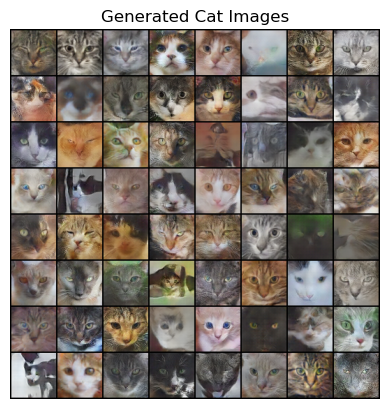

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Define the generator class (same as above)
class Generator(nn.Module):
    def __init__(self, nz, ngf=80):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Reload the trained generator
latent_dim = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG = Generator(latent_dim).to(device)
# Load the last checkpoint or specify the checkpoint filename
checkpoint = torch.load("generatorcat2.pth", map_location=device)
netG.load_state_dict(checkpoint)

# Generate new images
num_samples = 64 # Number of images to generate
fixed_noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)

# Generate images
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()
    grid = torchvision.utils.make_grid(fake_images, normalize=True)
    save_image(fake_images, 'generated_cat_images.png', nrow=8, normalize=True)

# Display generated images
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.title("Generated Cat Images")
plt.axis("off")
plt.show()
